In [2]:
import os
import re
import tqdm
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib
import torch
import torch.nn as nn
import torch.nn.functional as F
from hyperopt import hp
from hyperopt import fmin, tpe, space_eval, Trials

## Data

In [3]:
# path = "/content/drive/MyDrive/ML_data.json"
path = "data/band/ML_data.json"
repr_path = "mdl_data/representations_e"
df_in = pd.read_json(path)

# read structure representations
available = sorted(os.listdir(repr_path))
lookup = dict()
for idx, fn in enumerate(available):
    pmg_id = int(fn.split('_')[1])
    lookup[pmg_id] = idx
    
def load_from_id(pmg_id):
    try:
        fn = available[lookup[pmg_id]]
    except KeyError:
        #print(f"Missing representation vector for pymatgen ID: {pmg_id}")
        return float('nan')
    reprpath = os.path.join(repr_path, fn)
    return torch.load(reprpath)

In [4]:
df_in['pmg_ids'] = df_in['filename'].apply(lambda x: int(re.findall(r'\d+', x)[0]))
df_in['struct_feat'] = df_in['pmg_ids'].apply(load_from_id)

# split into individual bands
df = pd.concat([df_in] * 10, ignore_index=True)
N = len(df_in.index)
for i in range(10):
    start = 100 * (i%10)
    end = 100 * (i%10) + 100
    df.loc[N*i:N*(i+1), 'PBE'] = df.loc[N*i:N*(i+1), 'PBE'].apply(lambda x: x[start:end])
    df.loc[N*i:N*(i+1), 'HSE'] = df.loc[N*i:N*(i+1), 'HSE'].apply(lambda x: x[start:end])
df = df.sort_values('pmg_ids').reset_index(drop=True)

final_df = df.dropna()
final_df = final_df[final_df['PBE'].apply(len) > 0]

In [5]:
X_data = np.vstack(final_df['PBE'].values)
struct_data = torch.vstack(tuple(final_df['struct_feat'].values))
y_data = np.vstack(final_df['HSE'].values)

In [6]:
X_train, X_test, struct_train, struct_test, y_train, y_test = train_test_split(X_data, struct_data, y_data, test_size=0.1, shuffle=True)
X_train, X_val, struct_train, struct_val, y_train, y_val = train_test_split(X_train, struct_train, y_train, test_size=0.11, shuffle=True)

In [7]:
# Generate dataset 
class BandstructureDataset(Dataset):
    def __init__(self, X, struct, y):
        self.X = torch.Tensor(X)  # store X as a pytorch Tensor
        self.struct = torch.Tensor(struct) # store structure as pytorch Tensor
        self.y = torch.Tensor(y) # store Y as a pytorch Tensor
        self.len=len(self.X)                # number of samples in the data 

    def __getitem__(self, index):
        return self.X[index], self.struct[index], self.y[index] # get the appropriate item

    def __len__(self):
        return self.len

In [8]:
train_data = BandstructureDataset(X_train, struct_train, y_train)# fill in arguments
val_data = BandstructureDataset(X_val, struct_val, y_val)# fill in arguments
test_data = BandstructureDataset(X_test, struct_test, y_test)# fill in arguments

batch_size = 64 # fill in batch size
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)# fill in shuffle argument
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)# fill in shuffle argument
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)# fill in shuffle argument

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(30990, 100)
(3831, 100)
(3870, 100)


## Model Architecture

In [9]:
include_repr = 1
include_resid = 1
class BandstructureCNN(torch.nn.Module):
    def __init__(self, convlayers=3, channels=128, kernelsize=8, iosize=100, reprsize=100):
        super().__init__()
        self.n_conv = convlayers
        self.inputsize = iosize
        self.conv1 = nn.Conv1d(1, channels, kernel_size=kernelsize)
        self.bn = nn.BatchNorm1d(channels)
        
        self.convs = nn.ModuleList([nn.Conv1d(channels, channels, kernel_size=kernelsize) for i in range(convlayers-1)])

        self.fc1 = nn.Linear((self.inputsize - self.n_conv*(kernelsize - 1)) * channels + reprsize, self.inputsize * 2)
        self.fc2 = nn.Linear(self.inputsize * 2, self.inputsize)
        self.fc3 = nn.Linear(self.inputsize * 2, self.inputsize)
        
    def forward(self, x, representation):
        # Apply convolutions
        x1 = F.relu(self.bn(self.conv1(x)))
        for conv in self.convs:
            x1 = F.relu(self.bn(conv(x1)))
        # Apply MLP
        x2 = torch.concat((torch.flatten(x1, 1, 2), representation * include_repr), axis=1) # concat repr
        x3 = F.leaky_relu(self.fc1(x2))
        x4 = torch.concat((F.leaky_relu(self.fc2(x3)), x.squeeze() * include_resid), axis=1) # residual connection
        x5 = self.fc3(x4)
        return x5

device = 'cuda'
model = BandstructureCNN().to(device)
for batch in train_dataloader:
    X, struct, Y = batch
    X = X.to(device)[:,500:600].unsqueeze(1)
    out = model(X, struct)
    print(out.shape)
    break

In [10]:
def train(model, dataloader, optimizer, device):
    
    '''
    A function train on the entire dataset for one epoch .
    
    Args: 
        model (torch.nn.Module): your model from before 
        dataloader (torch.utils.data.DataLoader): DataLoader object for the train data
        optimizer (torch.optim.Optimizer(()): optimizer object to interface gradient calculation and optimization 
        device (str): Your device (usually 'cuda:0' for your GPU)
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''

    epoch_loss = []
    model.train() # Set model to training mode 
    
    for batch in dataloader:    
        X, struct, y = batch
        X = X.to(device).unsqueeze(1)
        struct = struct.to(device)
        y = y.to(device).unsqueeze(1)
        
        # train your model on each batch here 
        y_pred = model(X, struct)
        
        loss = nn.functional.mse_loss(y_pred, y.squeeze(1))
        epoch_loss.append(loss.item())
        
        # run backpropagation given the loss you defined
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return np.array(epoch_loss).mean()


def validate(model, dataloader, device):
    
    '''
    A function validate on the validation dataset for one epoch .
    
    Args: 
        model (torch.nn.Module): your model for before 
        dataloader (torch.utils.data.DataLoader): DataLoader object for the validation data
        device (str): Your device (usually 'cuda:0' for your GPU)
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''
    
    val_loss = []
    model.eval() # Set model to evaluation mode 
    with torch.no_grad():    
        for batch in dataloader:
            X, struct, y = batch
            X = X.to(device).unsqueeze(1)
            struct = struct.to(device)
            y = y.to(device).unsqueeze(1)
            
            # validate your model on each batch here 
            y_pred = model(X, struct)

            loss = nn.functional.mse_loss(y_pred, y.squeeze(1))
            val_loss.append(loss.item())
            
    return np.array(val_loss).mean()


## Hyperparameter Optimization

In [19]:
hyper_dict = {
    "convlayers": [1, 2, 3],
    "channels": [64, 96, 128, 160, 192, 256],
    "kernelsize": [3, 4, 5, 6, 7, 8, 9]
}

parameter_space =  { "convlayers": hp.choice("convlayers", hyper_dict['convlayers']),
                    "channels": hp.choice("channels", hyper_dict['channels']),
                    "kernelsize": hp.choice("kernelsize", hyper_dict['kernelsize'])
                    }

In [31]:
device = 'cuda:0'
def model_evaluation(args):
    '''Take suggested arguments and calculate loss based on one training run'''
    mod = BandstructureCNN(args['convlayers'], args['channels'], args['kernelsize'], reprsize=300).to(device)
    optimizer = torch.optim.Adam(mod.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=50, verbose=True)
    loss = 10
    print(f"Training {args['convlayers']} layers, {args['channels']} channels, {args['kernelsize']} kernel")
    for epoch in range(50):
        train_loss = train(mod, train_dataloader, optimizer, device=device)
        val_loss = validate(mod, val_dataloader, device=device)
        scheduler.step(val_loss)
        loss = val_loss
        if epoch%10 == 0:
            print(epoch)
    return loss

In [32]:
trials = Trials()
best = fmin(model_evaluation, parameter_space, algo=tpe.suggest, max_evals=40, trials=trials)

Training 3 layers, 128 channels, 4 kernel                                                                              
0                                                                                                                      
10                                                                                                                     
20                                                                                                                     
30                                                                                                                     
40                                                                                                                     
Training 1 layers, 256 channels, 7 kernel                                                                              
0                                                                                                                      
10                                      

10                                                                                                                     
20                                                                                                                     
30                                                                                                                     
40                                                                                                                     
Training 1 layers, 64 channels, 5 kernel                                                                               
0                                                                                                                      
10                                                                                                                     
20                                                                                                                     
30                                      

30                                                                                                                     
40                                                                                                                     
Training 1 layers, 256 channels, 7 kernel                                                                              
0                                                                                                                      
10                                                                                                                     
20                                                                                                                     
30                                                                                                                     
40                                                                                                                     
Training 1 layers, 256 channels, 9 kerne

Training 1 layers, 256 channels, 3 kernel                                                                              
0                                                                                                                      
10                                                                                                                     
20                                                                                                                     
30                                                                                                                     
40                                                                                                                     
Training 2 layers, 160 channels, 9 kernel                                                                              
0                                                                                                                      
10                                      

In [83]:
print(best)
losses = np.array(trials.losses())
nchs = []
nconvs = []
kers = []
for trial in trials.trials:
    valset = trial['misc']['vals']
    nconv = hyper_dict['convlayers'][valset['convlayers'][0]]
    nch = hyper_dict['channels'][valset['channels'][0]]
    ker = hyper_dict['kernelsize'][valset['kernelsize'][0]]
    nchs.append(nch)
    kers.append(ker)
    nconvs.append(nconv)
nchs = np.array(nchs)
nconvs = np.array(nconvs)
kers = np.array(kers)

{'channels': 5, 'convlayers': 0, 'kernelsize': 0}


### Hyperopt results
channels[5] -> 256

convlayers[0] -> 1

kernelsize[0] -> 3

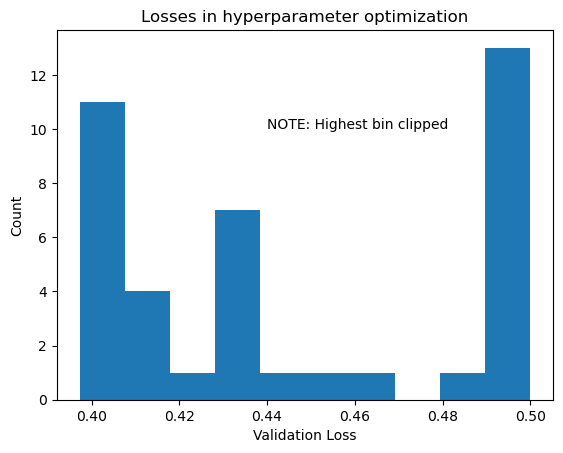

In [108]:
plt.hist(np.clip(losses, 0, 0.5))
plt.title("Losses in hyperparameter optimization")
plt.text(0.44, 10, "NOTE: Highest bin clipped")
plt.ylabel("Count")
plt.xlabel("Validation Loss")
plt.show()

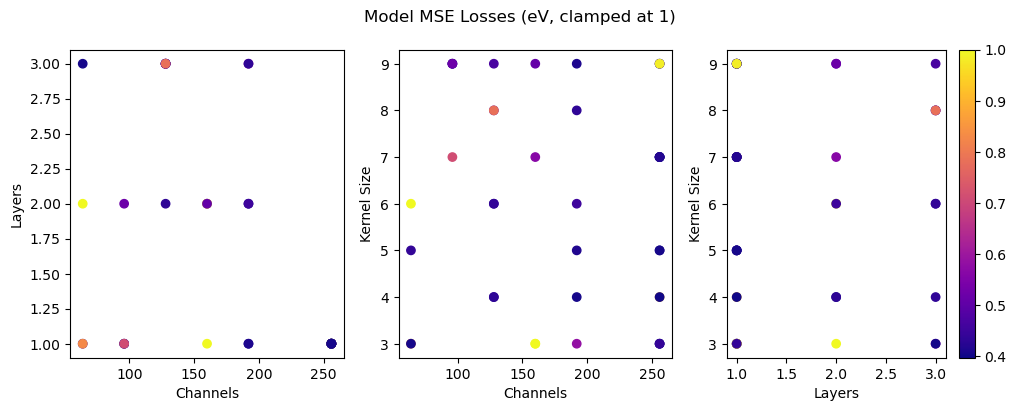

In [92]:
losses_clip = np.clip(losses, 0, 1)
fig, axes = plt.subplots(1,3,figsize=(12,4))
# axes[0].tricontourf(nchs, nconvs, losses_clip, 20, cmap='plasma')
axes[0].scatter(nchs, nconvs.astype(int), c=losses_clip, cmap='plasma')
axes[0].set_xlabel("Channels")
axes[0].set_ylabel("Layers")
# axes[1].tricontourf(nchs, kers, losses_clip, 20, cmap='plasma')
axes[1].scatter(nchs, kers, c=losses_clip, cmap='plasma')
axes[1].set_xlabel("Channels")
axes[1].set_ylabel("Kernel Size")
# axes[2].tricontourf(nconvs, kers, losses_clip, 20, cmap='plasma')
sc = axes[2].scatter(nconvs.astype(int), kers, c=losses_clip, cmap='plasma')
axes[2].set_xlabel("Layers")
axes[2].set_ylabel("Kernel Size")
fig.colorbar(sc)
fig.suptitle("Model MSE Losses (eV, clamped at 1)")
plt.show()

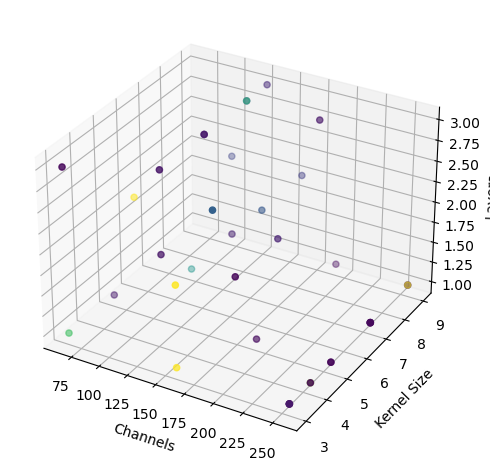

In [98]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(nchs, kers, nconvs, c=losses_clip)

ax.set_xlabel('Channels')
ax.set_ylabel('Kernel Size')
ax.set_zlabel('Layers')

plt.tight_layout()
plt.show()

## Training and Evaluation

In [11]:
# device to train on
device = 'cuda:0'
# define your model
#model = BandstructureCNN(convlayers=1, channels=256, kernelsize=3, reprsize=300).to(device) # hyperopt's choice
model = BandstructureCNN(reprsize=300).to(device)

# define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=50, verbose=True)

In [12]:
print("epoch", "train loss", "validation loss")

val_loss_curve = []
train_loss_curve = []

for epoch in range(401):
    
    # Compute train your model on training data
    epoch_loss = train(model, train_dataloader, optimizer,  device=device)
    
    # Validate your on validation data 
    val_loss = validate(model, val_dataloader, device=device) 
    scheduler.step(val_loss)
    
    # Record train and loss performance 
    train_loss_curve.append(epoch_loss)
    val_loss_curve.append(val_loss)
    
    if epoch % 25 == 0:
        print(epoch, epoch_loss, val_loss)
    
    # save model 
    if epoch % 50 == 0:
        torch.save(model.state_dict(), "{}/cnn_calib_{}.pt".format("cnnmodel_e", epoch))

epoch train loss validation loss
0 20.2101251348085 4.4858821275333565
25 0.6147230160643452 0.3748736888170242
50 0.36776563597785444 0.3699247068415085
75 0.38087394794775653 0.46498123879233993
Epoch 00080: reducing learning rate of group 0 to 5.0000e-04.
100 0.348588557272535 0.39773858214418095
125 0.26935384403338136 0.3254990700011452
150 0.24211428809872607 0.3144579021881024
175 0.2328881278403641 0.3208826002354423
Epoch 00190: reducing learning rate of group 0 to 2.5000e-04.
200 0.225431965587219 0.31995534207671883
225 0.19507121959912407 0.32498029290388025
Epoch 00241: reducing learning rate of group 0 to 1.2500e-04.
250 0.17409438253524376 0.3147982915863395
275 0.16169689014630834 0.31858217986300585
Epoch 00292: reducing learning rate of group 0 to 6.2500e-05.
300 0.1518866668983372 0.31668658908456565
325 0.13802801443974383 0.3268808030212919
Epoch 00343: reducing learning rate of group 0 to 3.1250e-05.
350 0.12532665364674686 0.33156343512237074
375 0.11727246535346

In [21]:
model.load_state_dict(torch.load("cnnmodel_e/cnn_calib_400.pt"))

<All keys matched successfully>

In [22]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

model.eval()
Xs = []
y_preds = []
y_trues = []
with torch.no_grad():    
    for batch in test_dataloader: # probably a more efficient way to do this? not sure
        X, struct, y = batch
        Xs.append(X)
        X = X.to(device).unsqueeze(1)
        struct = struct.to(device)
        y = y.to(device).unsqueeze(1)
        y_pred = model(X, struct).detach().cpu().numpy()
        y_true = y.squeeze(1).detach().cpu().numpy()
        y_preds.append(y_pred)
        y_trues.append(y_true)

X = np.concatenate(Xs, axis=0)
y_t = np.concatenate(y_trues, axis=0)
y_p = np.concatenate(y_preds, axis=0)

print("Model:", mean_absolute_error(y_t, y_p))
print("PBE:", mean_absolute_error(y_t, X))

Model: 0.24400175
PBE: 0.23833181


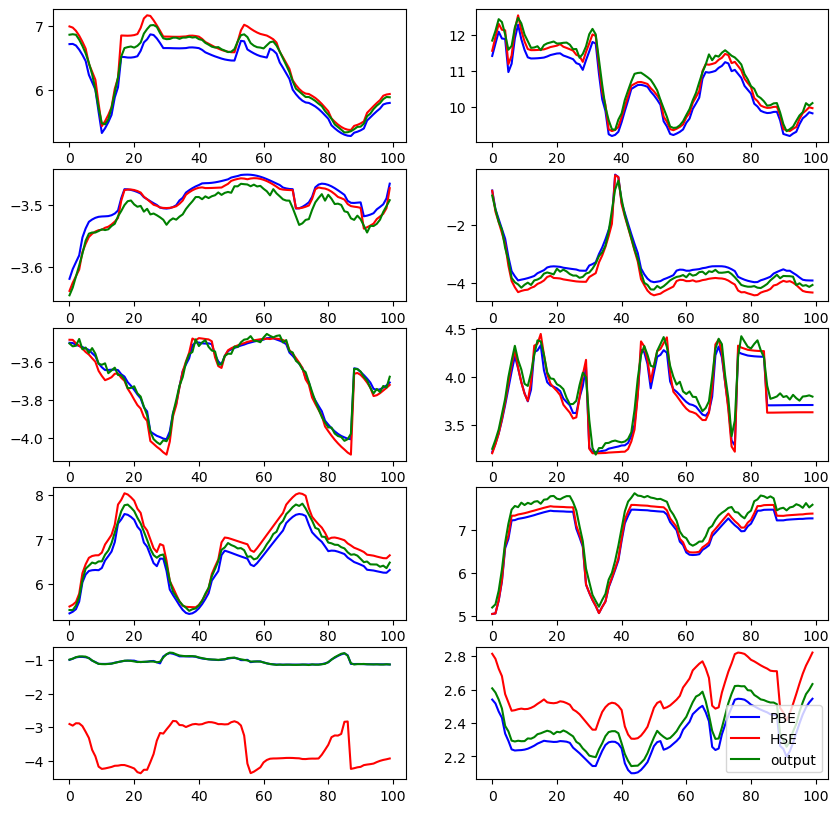

In [23]:
fig, axes = plt.subplots(5,2, figsize=(10,10))
offset=20
for index in range(10):
    X_band = X[index+offset].squeeze()
    y_true_band = y_t[index+offset]
    y_pred_band = y_p[index+offset]
    axes[index%5][index//5].plot(X_band,'b-',label='PBE')
    axes[index%5][index//5].plot(y_true_band, 'r-',label='HSE')
    axes[index%5][index//5].plot(y_pred_band,'g-',label='output')
plt.legend()
plt.show()